In [ ]:
import numpy as np

class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-6

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This solution is correct if vectors(gradients) lie in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    dps[(i,j)] = np.dot(vecs[i], vecs[j])
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    dps[(i,i)] = np.dot(vecs[i], vecs[i])
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0   
                    dps[(j, j)] = np.dot(vecs[j], vecs[j])
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j),c,d]
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))
    
    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])
        
        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)
        
        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]
    
        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]
                
        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec   
        return sol_vec, nd




In [ ]:
import numpy as np
from autograd import grad
import autograd.numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def f1(x):
    return (x[0]+1)/(-x[0]**2+3*x[0]-x[1]**2+3*x[1]+3.5)
def f2(x):
    return (x[0]**2-2*x[0]+x[1]**2-8*x[1]+20)/x[1]

def g1(x):
    return -2*x[0]-x[1]+6
def g2(x):
    return -3*x[0]-x[1]+8
def g3(x):
    return -x[0]+x[1]+1
def g4(x):
    return x[0]-1
def g5(x):
    return x[1]-1

g1_df = grad(g1)
g2_df = grad(g2)
g3_df = grad(g3)
g4_df = grad(g4)
g5_df = grad(g5)

consp = ({'type': 'ineq',
          'fun' : lambda x: np.array([g1(x)])},
         {'type': 'ineq',
          'fun' : lambda x: np.array([g2(x)])},
          {'type': 'ineq',
          'fun' : lambda x: np.array([g3(x)])},
          {'type': 'ineq',
          'fun' : lambda x: np.array([g4(x)])},
          {'type': 'ineq',
          'fun' : lambda x: np.array([g5(x)])},
        )

def rosen(x,y):
    """The Rosenbrock function"""
    return np.sqrt(np.sum((x-y)**2))

def find_min(y,n):
    x = np.random.rand(1,n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point",
                constraints=consp,method='SLSQP', options={'disp': False})
    return res.x

In [ ]:
import autograd.numpy as np
from autograd import grad

from matplotlib import pyplot as plt

# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from scipy.linalg import norm
from matplotlib import pyplot as plt

def get_d_paretomtl(grads,value, constraint,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
       
    # solve QP 
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    test = np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)
    if test.ndim == constraint.ndim:
      vec =  np.concatenate((test, constraint), axis = 0)
    else:
      vec = test
    
    vec = vec/norm(vec)

    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)
    
    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))

    num_cons = len(constraint)
    if num_cons != 0:
      weight_cons = sol[-num_cons:]
      weight = np.array(list([weight0]) + list([weight1]) + weight_cons)
    else:
      weight = np.stack([weight0, weight1])
    return weight


def get_d_paretomtl_init(grads,value,constraint, weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
    
    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        test = np.dot(w[idx],grads)
        if constraint.ndim == test.ndim:
          vec =  np.concatenate((test, constraint), axis = 0)
        else:
          vec = test
        vec = vec/norm(vec)
        
        sol, nd = MinNormSolver.find_min_norm_element(vec)
    
    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))

    num_cons = len(constraint)
    if num_cons != 0:
      weight_cons = sol[-num_cons:]
      weight = np.array(list([weight0]) + list([weight1]) + weight_cons)
    else:
      weight = np.stack([weight0, weight1])

    return weight


def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

def circle_points2(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = np.pi / 30. if min_angle is None else min_angle
    ang1 = np.pi * 8 / 20. if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]


# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)


def pareto_mtl_search(ref_vecs,i, t_iter = 100, n_dim = 2, step_size = 2, sigma = 1, kappa = 0.95, eps = 0.01, count_check = 10):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(0, 1, n_dim)
    x = find_min(x, 2)
    f_all = []
    x_all = []
    df_all = []

    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        f, f_dx = concave_fun_eval(x)
        # f, f_dx = convex_fun_eval(x)
        constraint = []
        value_set = [[g1(x),g1_df(x)], [g2(x),g2_df(x)], [g3(x),g3_df(x)], [g4(x),g4_df(x)], [g5(x),g5_df(x)]]
        for f_value in value_set:
          if f_value[0]<=eps:
            constraint.append(-f_value[1])
        constraint = np.array(constraint)
        weights =  get_d_paretomtl_init(f_dx,f, constraint, ref_vecs,i)

        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten()
        else:
          direction_descent = -np.dot(weights.T,f_dx).flatten()
          
        x = x + step_size * direction_descent
        x = find_min(x, n_dim)
        x_all.append(x)
    
    count = 0
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)
        f_all.append(f)
        df_all.append(f_dx)
        constraint = []
        value_set = [[g1(x),g1_df(x)], [g2(x),g2_df(x)], [g3(x),g3_df(x)], [g4(x),g4_df(x)], [g5(x),g5_df(x)]]
        for f_value in value_set:
          if f_value[0]<=eps:
            constraint.append(-f_value[1])
        constraint = np.array(constraint)

        weights =  get_d_paretomtl(f_dx,f,constraint, ref_vecs,i)
        
        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten()
          x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
          #x_next = find_min(x_next, n_dim)
          f_after, f_dx_after = concave_fun_eval(x_next)
          #f_after, f_dx_after = convex_fun_eval(x_next)
          
          if np.dot(weights[0:len(f_dx)].T,f_after).flatten() + np.dot(weights[len(f_dx):].T, constraint).flatten() <= np.dot(weights[0:len(f_dx)].T,f).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten() + sigma*np.dot(direction_descent.T, step_size * direction_descent):
            step_size *= kappa
        else:
          direction_descent = -np.dot(weights.T,f_dx).flatten()
          x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
          #x_next = find_min(x_next, n_dim)
          f_after, f_dx_after = concave_fun_eval(x_next)
          #f_after, f_dx_after = convex_fun_eval(x_next)
          
          if np.dot(weights.T,f_after) <= np.dot(weights.T, f) + sigma*np.dot(direction_descent.T, step_size * direction_descent):
            step_size *= kappa

        if -1/2*norm(direction_descent)**2 >= -0.01 or -1/2*norm(direction_descent)**2 <= 0.01:
          break
      
        x = x + step_size * direction_descent
        #x = find_min(x, n_dim)
        x_all.append(x)

    return x, f, x_all, f_all, df_all


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


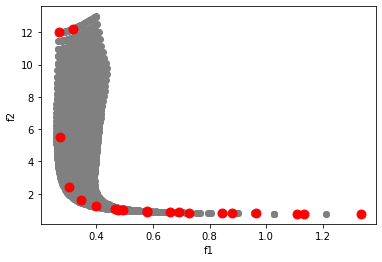

In [ ]:
def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])
    
### create the ground truth Pareto front ###
def create_pf_concave():
    ps2 = np.linspace(1, 4, num = 100)
    ps1 = np.linspace(1, 9/4, num = 100)
    pf = []
    
    for x1 in ps1:
      for x2 in ps2:
        if 2*x1+x2<=6 and 3*x1+x2<=8 and x1-x2<=1:
          x = np.array([x1, x2])
          f, f_dx = concave_fun_eval(x)
          pf.append(f)
            
    pf = np.array(pf)
    
    return pf

pf = create_pf_concave()
f_value_list = []
x_value_list = []

num = 20

weights = circle_points([1], [num])[0]
#weights = circle_points2(num)

for i in range(num):
        
    print(i)
        
    x, f, x_all, f_all, df_all = pareto_mtl_search(ref_vecs = weights,i = i)

    #x = find_min(x, 2)   
    # if x[0] >= 1 and x[0] <= 4 and x[1] >=1 and x[1]<=9/4 and 2*x[0]+x[1]<=6 and 3*x[0]+x[1]<=8 and x[0]-x[1]<=1:
    f_value_list.append(f)
    x_value_list.append(x)

f_value_list = np.array(f_value_list)
plt.scatter(pf[:,0],pf[:,1], c = 'gray')
plt.xlabel("f1")
plt.ylabel("f2")
plt.scatter(f_value_list[:,0], f_value_list[:,1], c = 'r', s = 80)
plt.show()